# Import libaries and Data

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [17]:

df = pd.read_csv("../additional_material/housing.csv")

df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Clean Data

In [18]:
# Check how many missing values each column has
df.isna().sum().sort_values(ascending=False).head(20)


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64

In [19]:
# Calculate percentage of missing values
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct.head(20)


PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
Condition2       0.000000
dtype: float64

In [26]:
# Drop variables that have extremely high missing values
vars_to_drop = ["PoolQC", "MiscFeature", "Alley"]

df = df.drop(columns=vars_to_drop)

In [27]:
# Handle remaining missing values: 

# -----------------------------
# 1. Replace missing values with explicit categories
# -----------------------------

# Fence -> NoFence
df["Fence"] = df["Fence"].fillna("NoFence")

# MasVnrType -> None
df["MasVnrType"] = df["MasVnrType"].fillna("None")

# FireplaceQu -> NoFireplace
df["FireplaceQu"] = df["FireplaceQu"].fillna("NoFireplace")

# LotFrontage -> 0
# Comment: LotFrontage is numeric, so we fill with 0
df["LotFrontage"] = df["LotFrontage"].fillna(0)

# Garage-related variables -> NoGarage
garage_cols = [
    "GarageQual",
    "GarageFinish",
    "GarageType",
    "GarageYrBlt",
    "GarageCond"
]

for col in garage_cols:
    df[col] = df[col].fillna("NoGarage")

# Basement-related variables -> NoBasement
basement_cols = [
    "BsmtFinType2",
    "BsmtExposure",
    "BsmtCond",
    "BsmtQual",
    "BsmtFinType1"
]

for col in basement_cols:
    df[col] = df[col].fillna("NoBasement")

# -----------------------------
# 2. Drop rows with missing values in specific columns
# -----------------------------

# Drop rows where MasVnrArea is missing
df = df.dropna(subset=["MasVnrArea"])

# Drop rows where Electrical is missing
df = df.dropna(subset=["Electrical"])


In [28]:
# Check again how many missing values each column has
df.isna().sum().sort_values(ascending=False).head(20)

Id              0
MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [29]:
# Check for duplicate rows
df.duplicated().sum()


np.int64(0)

# Inspect the target variable

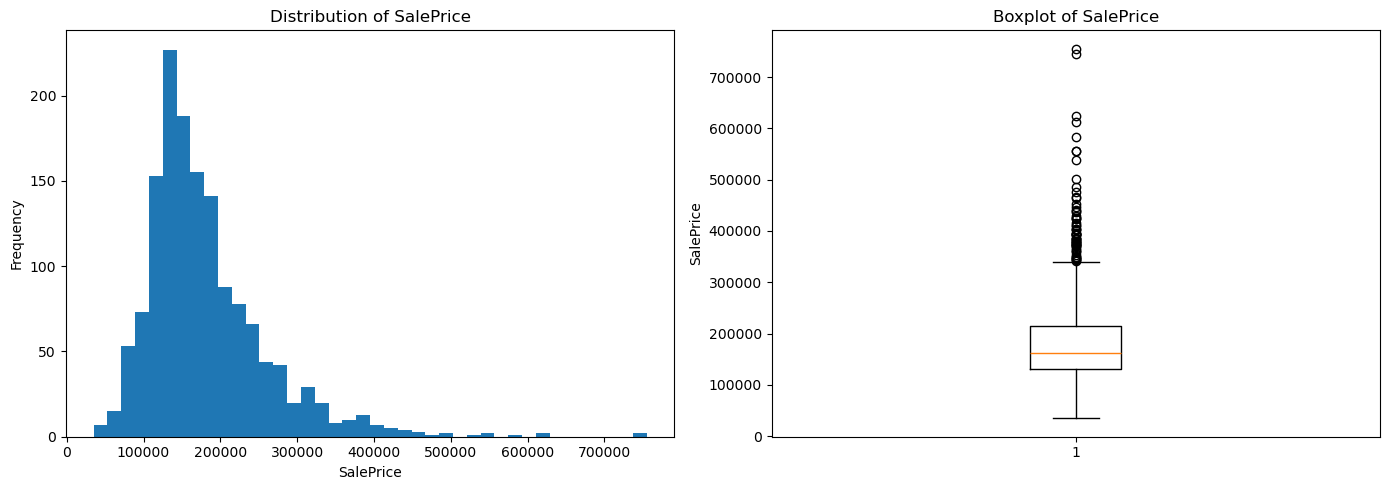

In [21]:
# Create a figure with two subplots (histogram + boxplot)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Histogram ---
axes[0].hist(df["SalePrice"], bins=40)
axes[0].set_title("Distribution of SalePrice")
axes[0].set_xlabel("SalePrice")
axes[0].set_ylabel("Frequency")

# --- Boxplot ---
# Boxplots help to detect outliers visually
axes[1].boxplot(df["SalePrice"], vert=True)
axes[1].set_title("Boxplot of SalePrice")
axes[1].set_ylabel("SalePrice")

plt.tight_layout()
plt.show()

# Select Variables for the initial model

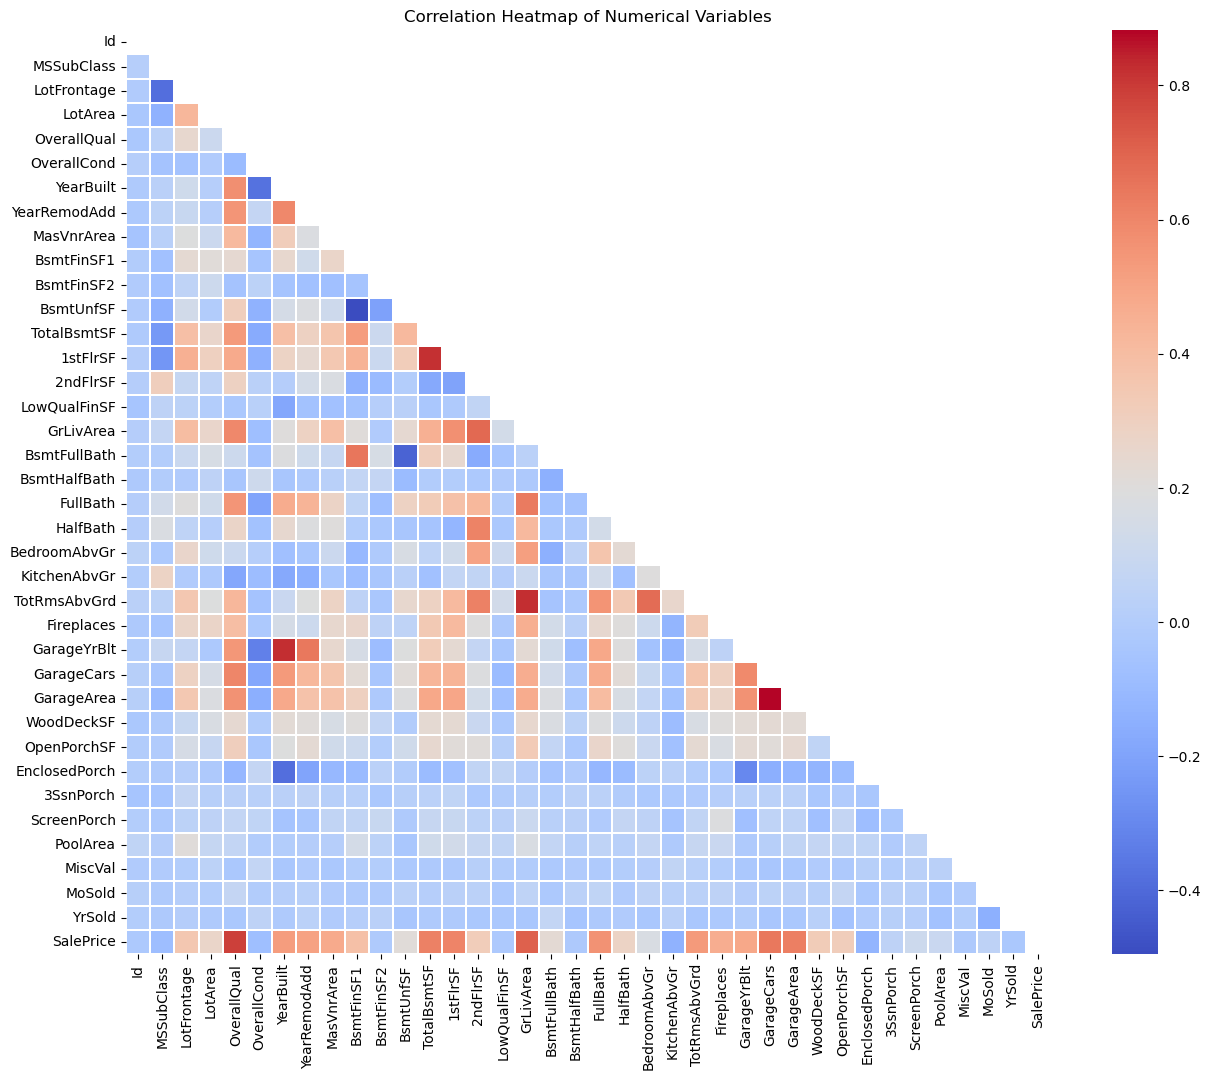

In [22]:


# --- Select only numerical columns ---
# Comment: This filters the dataframe to numeric variables only
numeric_df = df.select_dtypes(include=["int64", "float64"])

# --- Compute correlation matrix ---
corr_matrix = numeric_df.corr()

# --- Plot the heatmap ---
plt.figure(figsize=(16, 12))

# Comment: Using a mask hides the upper triangle of the heatmap to make it easier to read
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    fmt=".2f",
    square=True,
    linewidths=0.3
)

plt.title("Correlation Heatmap of Numerical Variables")
plt.show()


In [23]:


# --- Select only numeric columns ---
numeric_df = df.select_dtypes(include=["int64", "float64"])

# --- Compute correlation matrix ---
corr_matrix = numeric_df.corr().abs()  # absolute value of correlations

# --- Find pairs with correlation > 0.9 ---
# Comment: We remove self-correlations using a mask
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()  # convert matrix to long format
    .reset_index()
)

# Rename columns for clarity
high_corr_pairs.columns = ["Variable_1", "Variable_2", "Correlation"]

# Filter for correlations above threshold
result = high_corr_pairs[high_corr_pairs["Correlation"] > 0.7]

result


,Variable_1,Variable_2,Correlation
174,OverallQual,SalePrice,0.790982
225,YearBuilt,GarageYrBlt,0.825667
378,TotalBsmtSF,1stFlrSF,0.819530
478,GrLivArea,TotRmsAbvGrd,0.825489
492,GrLivArea,SalePrice,0.708624
637,GarageCars,GarageArea,0.882475


In [24]:

from scipy.stats import chi2_contingency
import itertools

# --- Select categorical variables ---
# Comment: We only take columns with dtype 'object' or 'category'
cat_cols = df.select_dtypes(include=["object", "category"]).columns

chi_results = []

# --- Loop through all unique pairs of categorical variables ---
for var1, var2 in itertools.combinations(cat_cols, 2):
    
    # Create contingency table
    contingency = pd.crosstab(df[var1], df[var2])
    
    # Skip if table is too small (Chi-square can't handle empty tables)
    if contingency.size == 0 or contingency.shape[0] < 2 or contingency.shape[1] < 2:
        continue
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    # Store the result
    chi_results.append({
        "Variable_1": var1,
        "Variable_2": var2,
        "p_value": p
    })

# Convert results to a DataFrame
chi_results_df = pd.DataFrame(chi_results)

# Sort by p-value ascending (strongest dependency first)
chi_results_df = chi_results_df.sort_values("p_value")

chi_results_df


,Variable_1,Variable_2,p_value
879,SaleType,SaleCondition,0.0
509,Exterior1st,Exterior2nd,0.0
7,MSZoning,Neighborhood,0.0
302,Neighborhood,Exterior2nd,0.0
854,GarageQual,GarageCond,0.0
...,...,...,...
377,Condition2,Heating,1.0
365,Condition2,RoofMatl,1.0
213,Utilities,CentralAir,1.0
81,Alley,LotConfig,1.0


In [25]:
significant_pairs = chi_results_df[chi_results_df["p_value"] < 0.05]
significant_pairs


,Variable_1,Variable_2,p_value
879,SaleType,SaleCondition,0.000000
509,Exterior1st,Exterior2nd,0.000000
7,MSZoning,Neighborhood,0.000000
302,Neighborhood,Exterior2nd,0.000000
854,GarageQual,GarageCond,0.000000
...,...,...,...
491,RoofMatl,BsmtFinType1,0.039789
132,LotShape,BsmtCond,0.040667
246,LotConfig,CentralAir,0.043632
739,BsmtFinType2,FireplaceQu,0.044014
